In [64]:
import numpy as np
import pymaster as nmt
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt 
import imp
import camb
import bandpowers
import numpy.linalg as LA

from multiprocessing import Pool, cpu_count

%matplotlib inline

In [2]:
import utils

In [53]:
import dynesty
from dynesty import plotting as dyplot
## import planck function 
from pysm.common import B as pf
from Fg_template import sync_ps, dust_ps
from Fg_template import corre_fore_simple

In [118]:
import pysm
from pysm.nominal import models
from pysm.common import convert_units

c30 = convert_units("uK_RJ", "uK_CMB", 30);
c95 = convert_units("uK_RJ", "uK_CMB", 95);
c150 = convert_units("uK_RJ", "uK_CMB", 150);

c353 = convert_units("uK_RJ", "uK_CMB", 353); 

In [55]:
def vecp_real(mat):
    '''
    This returns the unique elements of a symmetric matrix 
    '''
    dim = mat.shape[0]
    
    vec = np.zeros(int(dim*(dim+1)/2))
    counter = 0
    for iDiag in range(0,dim):
        vec[counter:counter+dim-iDiag] = np.diag(mat,iDiag)
        
        counter = counter + dim - iDiag

    return vec

def vecp_jx(mat):
    y = np.triu(mat, k = 0)
    vecp_y = y[y != 0]
    return vecp_y

def calculate_vecp(cl_hat, Nf):
    
    '''
    Turn the matrix into X-form.
    '''
    lbin = len(cl_hat); nf_ind = int(Nf*(Nf+1)/2);
    Xall = np.ones(lbin*nf_ind);
    for l in range(lbin):
        Xall[l*nf_ind:(l+1)*nf_ind] = vecp_real(cl_hat[l])
    
    return(Xall)


##  -2lnL = (C_hat - C)*M^-1*(C_hat - C ^T)
def simple_likelihood(cl_hat,cl_th, Nf, M, sbin = 1):
    
    Xa = calculate_vecp(cl_hat - cl_th, Nf);
    M_inv = LA.inv(M);
    
    if sbin is not None:
        
        nf_ind = int(Nf*(Nf+1)/2)
        start = sbin*nf_ind
        
        Xa = Xa[start:]; 
        M_inv = M_inv[start:,start:]
    
    Xa = np.matrix(Xa);
    
    logL = -0.5*Xa*M_inv*np.transpose(Xa)
    
    return(logL[0,0])

In [120]:
Nside = 128;
nside = 128;

nmtlmax = 201
lmin = 2
lmax = 1521

bin_w = 20

Nf = 2; nf_ind = 3

In [39]:
b = nmt.NmtBin(Nside, nlb=bin_w, is_Dell=True, lmax=nmtlmax)
leff = b.get_effective_ells()
lbin = len(leff)
b_ind = np.arange(1,nbin+1)

In [14]:
camb_cl = utils.Gencl(0.05, raw_cl=1)

In [35]:
map30f = hp.read_map('/fnx/jianyao/Likelihood_data/ABSData/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('/fnx/jianyao/Likelihood_data/ABSData/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('/fnx/jianyao/Likelihood_data/ABSData/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('/fnx/jianyao/Likelihood_data/ABSData/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

vmap95 = hp.read_map('/fnx/jianyao/Likelihood_data/ABSData/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('/fnx/jianyao/Likelihood_data/ABSData/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)

ali_ma = hp.read_map('/fnx/jianyao/Likelihood_data/ABSData/ali_mask.fits',dtype=bool,verbose=0)

In [60]:
A_d_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/dust_template_353_BB_RJ.npy')
dust_dl_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/dust_BB_cross_fre_1p56_from_RJ.npy')


A_s_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/sync_template_30_BB_RJ.npy')
sync_dl_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/sync_BB_cross_fre_n3p0_from_RJ.npy')

In [121]:
sky_config = {'dust' : models("d1", nside), 'synchrotron' : models("s1", nside)}
sky = pysm.Sky(sky_config);

d95 = sky.dust(95)*c95; d150 = sky.dust(150)*c150;
# d353 = sky.dust(353)*c353

# s30 = sky.synchrotron(30)*c30;
s95 = sky.synchrotron(95)*c95; s150 = sky.synchrotron(150)*c150

In [146]:
maps_na = hp.read_map('/home/jianyao/NaMaster/test/maps.fits', field = None)

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


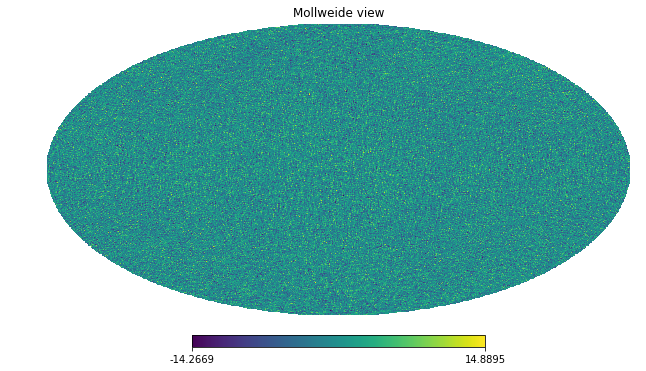

In [150]:
hp.mollview(maps_na[1])

In [36]:
est = bandpowers.BPE(mask_in = ali_ma, nside = 128, bin_w = bin_w, lmax = nmtlmax, wsp = True)

In [43]:
beam_low = 19;  SamNum = 50

cl_f_all = np.ones((SamNum, 3, est.lbin, Nf, Nf));
nl_all = np.zeros((SamNum, 3, est.lbin, Nf, Nf))

cpn = np.zeros((Nf, 2, 12*Nside**2)); ## CMB plus noise

Noise = np.zeros((Nf, 2, 12*Nside**2))

for n in range(SamNum):
    ''' mark '''
    cmb_i_0p05 = hp.synfast(camb_cl,nside=Nside,new=True,verbose=0)

    nmap95 = np.random.normal(0.,1.,size=vmap95.shape)*np.sqrt(vmap95)
    nmap150 = np.random.normal(0.,1.,size=vmap150.shape)*np.sqrt(vmap150)  

    cpn[0] = (cmb_i_0p05 + nmap95)[1:]; cpn[1] = (cmb_i_0p05 + nmap150)[1:]
    
    Noise[0] = nmap95[1:]; Noise[1] = nmap150[1:];
        
    ## EE EB BB-mode
    nl_all[n] = est.Cross_EB(Noise)
    cl_f_all[n] = est.Cross_EB(cpn)


In [46]:
marry_ali = utils.Marray_EEfirst(cl_f_all, nf_ind, 3, lbin, cl_f_all.shape[0]) ## (Nmode*lbin*nf_ind, SamNum)

cov_mat_BB_ali = np.cov(marry_ali[lbin*nf_ind*2:]) ##(select BB mode)

In [115]:
cov_mat_BB_ali.shape

(30, 30)

In [62]:
nl_mean_ali = np.mean(nl_all, axis = 0) ## EE EB BB

In [141]:
# np.random.seed(233)

mapcmb = hp.synfast(camb_cl,nside=Nside,new=True,verbose=0)

nmap95 = np.random.normal(0.,1.,size=vmap95.shape)*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=vmap150.shape)*np.sqrt(vmap150)

In [142]:
total = np.ones((Nf, 3, 12*Nside**2))
total[0] = mapcmb + nmap95 + s95 #+ d95;
total[1] = mapcmb + nmap150 + s150 #+ d150;

cl_hat_all = est.Cross_EB(total[:, 1:, :])

In [54]:
lensingB = utils.Gencl(r = 0, raw_cl = True) ## only lensing BB; TT EE BB TE

bb_05 = utils.Gencl(r = 0.05, raw_cl = True, tensorBB_only=True) ##only tensor BB; ## 

In [143]:
npara = 2; Nsim = 1;

def prior(cube):
    
    r = cube[0]*0.3
    beta_s = cube[1]*2 - 4## from -4 to -2
#     beta_d = cube[2]*0.4 + 1.4 ## from 1.4 to 1.8
#     epsilon = cube[3];
    
    return [r, beta_s]#, beta_d, epsilon]

Mean = np.zeros((Nsim,npara)); Samples = np.zeros((Nsim, npara)); Weights = np.zeros(Nsim); Results = []

for n in range(Nsim):
    
    cl_hat_fore_ali = cl_hat_all[2] 
      
    def log_likelihood(cube, likelihood = 1):
        r_i = cube[0];
        beta_s = cube[1];
#         beta_d = cube[2];
#         epsilon = cube[3];

        bb_tensor = bb_05[0:nmtlmax+1]*r_i/0.05 

        bb_camb = bb_tensor + lensingB[2][0:nmtlmax+1] ## tensor BB + lensing BB 

        cl_th_i = b.bin_cell(bb_camb[0:nmtlmax+1])  ## theoretical bandpower 
        cl_th_test = np.ones((lbin, Nf, Nf));  ## BB cross power spectra
        for ell in range(lbin):
            cl_th_test[ell] *= cl_th_i[ell]

        fl_hat = sync_ps(A_s_RJ, beta_s, lbin) #+ dust_ps(A_d_RJ, beta_d, lbin) + corre_fore_simple(epsilon, A_d_RJ, A_s_RJ, beta_s, beta_d, lbin)

        ## gaussian
        if likelihood == 1:

            C_l = cl_th_test + nl_mean_ali[2] + fl_hat;
            logL = simple_likelihood(cl_hat_fore_ali, C_l, Nf = Nf, M = cov_mat_BB_ali, sbin = 1)
   
        return np.real(logL)
    
    with Pool(cpu_count()-1) as executor:
        
        sampler = dynesty.NestedSampler(log_likelihood, prior, npara, nlive=400, pool=executor, queue_size=cpu_count(), bootstrap = 0)
        sampler.run_nested(dlogz = 0.1)
        results = sampler.results
    
#     Results.append(results)
    
#     if n == 0 : 
#         samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
    
#     else: 
#         _samples, _weights = results.samples, np.exp(results.logwt - results.logz[-1])
#         samples = np.r_[samples, _samples];
#         weights = np.r_[weights, _weights];

3894it [00:03, 1186.89it/s, +400 | bound: 9 | nc: 1 | ncall: 19691 | eff(%): 21.807 | loglstar:   -inf < -51.165 <    inf | logz: -58.538 +/-  0.179 | dlogz:  0.000 >  0.100]


In [134]:
# truth = np.array([0.05, -3.0, 1.558, 0.1])

# truth = np.array([0.05, 1.558])

truth = np.array([0.05, -3.0])
                  
sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

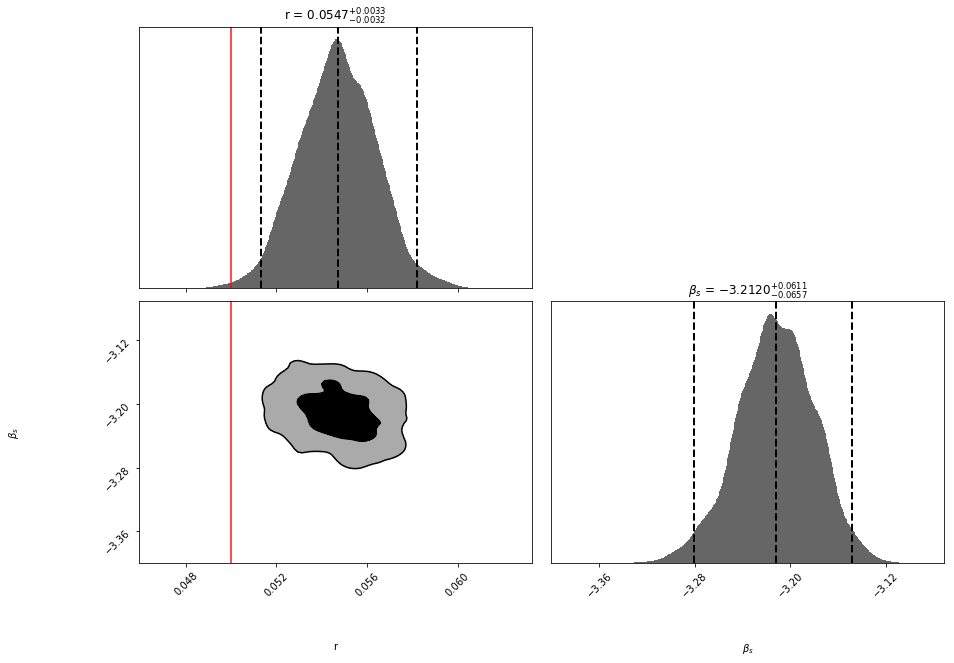

In [144]:
for n in range(Nsim):
    
    labels = ['r', r'$\beta_s$']#,r'$\beta_d$', r'epislon']; 
    fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
    axes = axes.reshape((npara, npara)) 

    fig, ax = dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                     labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85